In [91]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

In [92]:
import pandas_datareader.data as web

In [93]:
IMAGES_PATH = Path("../images/")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [94]:
import seaborn as sns
import talib

In [95]:
from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [96]:
ticker='portfolio'

In [97]:
class DataPrep:
    
    def __init__(self, batch, source=Path("../data/assets.h5"), destination=Path("../data/data.h5") ):
        self.source = source
        self.batch = batch
        self.path = 'yfinance/prices/{}/'.format(batch)
        self.destination = destination
        self.dest_path = 'model_data/portfolio/{}'.format(batch)
        
        
    def _extract(self,tickers):
        prices = {}
        
        for tick in tickers:
            prices.update({tick:pd.read_hdf(self.source, self.path + f'{tick.lower()}')})
        
        stocks = pd.read_hdf('../data/assets.h5', 'us_equities/stocks')
        return prices,stocks
        
    def _load(self,prices):
        results = []
        for tick,data in prices.items():
            data = data.reset_index().assign(ticker=tick)
            results.append(data)
        results = (pd.concat(results, axis = 0).set_index(['ticker','Date']))
    
        results = results.drop('Close', axis = 1).rename(columns=str.lower).rename(columns = {'adj close': 'close'}).assign(volume = lambda x: x.volume.div(1000))
    
        return results
    
    def _compute_bb(self,close):
        high, mid, low = BBANDS(close, timeperiod=20)
        return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)
    
    def _compute_atr(self,price_data):
        df = ATR(price_data.high, price_data.low, 
                 price_data.close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    
    def _compute_macd(self,close):
        macd = MACD(close)[0]
        return (macd - np.mean(macd))/np.std(macd)
    
    def _compute_other_mm(self,frame_tr):
        
        # Plus/minus directional index
        
        df= pd.DataFrame()
            
        df['PLUS_DM'] = talib.PLUS_DM(frame_tr.high, frame_tr.low, timeperiod=10)
        df['MINUS_DM'] = talib.MINUS_DM(frame_tr.high, frame_tr.low,timeperiod=10)
            
            # Average directional movement index
            
        df['ADX'] = talib.ADX(frame_tr.high, frame_tr.low, frame_tr.close, timeperiod=14)
            
            
            # percentage price oscillator(PPO)
        df['PPO'] = talib.PPO(frame_tr.close, fastperiod = 12, slowperiod=26, matype=0)
            
            # stochastic oscillator
            
        slowk, slowd = talib.STOCH(frame_tr.high,
                           frame_tr.low,
                           frame_tr.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
        df['STOCH'] = slowd / slowk
            
            
            # Money flow index
        df['MFI'] = talib.MFI(frame_tr.high,frame_tr.low, frame_tr.close,
                                       frame_tr.volume, timeperiod =14)
            
        return df
    
    
    def _compute_other_mm(self,frame_tr):
        
        # Plus/minus directional index
        
        df= pd.DataFrame()
            
        df['PLUS_DM'] = talib.PLUS_DM(frame_tr.high, frame_tr.low, timeperiod=10)
        df['MINUS_DM'] = talib.MINUS_DM(frame_tr.high, frame_tr.low,timeperiod=10)
            
            # Average directional movement index
            
        df['ADX'] = talib.ADX(frame_tr.high, frame_tr.low, frame_tr.close, timeperiod=14)
            
            
            # percentage price oscillator(PPO)
        df['PPO'] = talib.PPO(frame_tr.close, fastperiod = 12, slowperiod=26, matype=0)
            
            # stochastic oscillator
            
        slowk, slowd = talib.STOCH(frame_tr.high,
                           frame_tr.low,
                           frame_tr.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
        df['STOCH'] = slowd / slowk
            
            
            # Money flow index
        df['MFI'] = talib.MFI(frame_tr.high,frame_tr.low, frame_tr.close,
                                       frame_tr.volume, timeperiod =14)
            
        return df
        
    def _compute_chaikin_AD(self,frame_tr):
        
         return talib.AD(frame_tr.high,
                       frame_tr.low,
                       frame_tr.close,
                       frame_tr.volume)

    
    def transform(self,prices, stocks):
        
        #remove stocks with lower observations
        idx = pd.IndexSlice
        year = 252 #252 trading days in year
        min_obs = year  # requires 5 year pricing data per ticker
        nobs = prices.groupby(level='ticker').size()
    
        #keep those that exceed the limit
        keep = nobs[nobs > min_obs].index
        prices = prices.loc[idx[keep, : ], :]
    
        #align prices and meta data
        shared = (prices.index.get_level_values('ticker').unique()
                  .intersection(stocks.index))
        stocks = stocks.loc[shared, :]
        prices = prices.loc[idx[shared, :], :]
    
    # select investment universe based upong dollar_vol
    
        prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)
        prices['dollar_vol_1m']=(prices.dollar_vol.groupby('ticker').rolling(window=21).mean()).values
        prices['dollar_vol_rank'] = (prices.groupby('Date')
                             .dollar_vol_1m
                             .rank(ascending=False))
    
        lags = [1, 5, 10, 21, 42, 63]
        periods = [5,21,63]
    
        #compute trend indicators
    
        #1. Moving average
        for t in periods:
            prices[f'SMA_{t}'] = prices.groupby('ticker').close.transform(lambda x: talib.SMA(x, timeperiod = t))
     
        #lagged returns
        for lag in lags:
            prices[f'return_{lag}d'] = prices.groupby('ticker').close.transform(lambda x: np.log(x/x.shift(lag)))
        
        #overlap studies
    
        prices['HT_TRENDLINE'] = prices.groupby('ticker').close.transform(talib.HT_TRENDLINE)

        #bollinger bands
    
        prices = prices.join(prices.groupby('ticker', group_keys=False).close.apply(self._compute_bb))
        prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
        prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
    
        # 2. Momentum indicators
    
        #RSI
    
        prices['rsi'] = prices.groupby('ticker').close.transform(talib.RSI)
    
        #macd
    
        prices['macd'] = (prices.groupby('ticker', group_keys=False)
                          .close
                          .apply(self._compute_macd))
        #other momentum indicators
    
        prices = prices.join(prices.groupby('ticker',group_keys=False).apply(self._compute_other_mm))
    
        #volume indicators
    
        prices['AD'] = prices.groupby('ticker', group_keys=False).apply(self._compute_chaikin_AD)
    
        #volatility indicators
        prices['atr'] = prices.groupby('ticker', group_keys=False).apply(self._compute_atr)
    
    
        #forward returns
    
        for t in [1]:
            prices[f'target_{t}d'] = prices[f'return_{t}d'].shift(-t)
                   
        
        
        prices.dropna(inplace = True)
            
    #
        prices.to_hdf(self.destination, self.dest_path )
            
        print("transformed portofio data can be found in {} under {}".format(self.destination, self.dest_path))
            
        return prices
            
    def extract_load_transform(self,tickers):
        
        prices,stocks = self._extract(tickers)
        
        return self.transform(self._load(prices),stocks)
    

In [98]:
tickers = ['AAPL', 'MSFT',
           'NKE', 'DIS', 
           'AAL', 'ZG', 
           'VTI' ]

In [99]:
train = DataPrep('train')

z=train.extract_load_transform(tickers)

transformed portofio data can be found in ../data/data.h5 under model_data/portfolio/train


In [100]:
test = DataPrep('test')
t = test.extract_load_transform(tickers)

transformed portofio data can be found in ../data/data.h5 under model_data/portfolio/test


In [101]:
corr_mat = z.drop('target_1d', axis =1).corr(method='spearman')

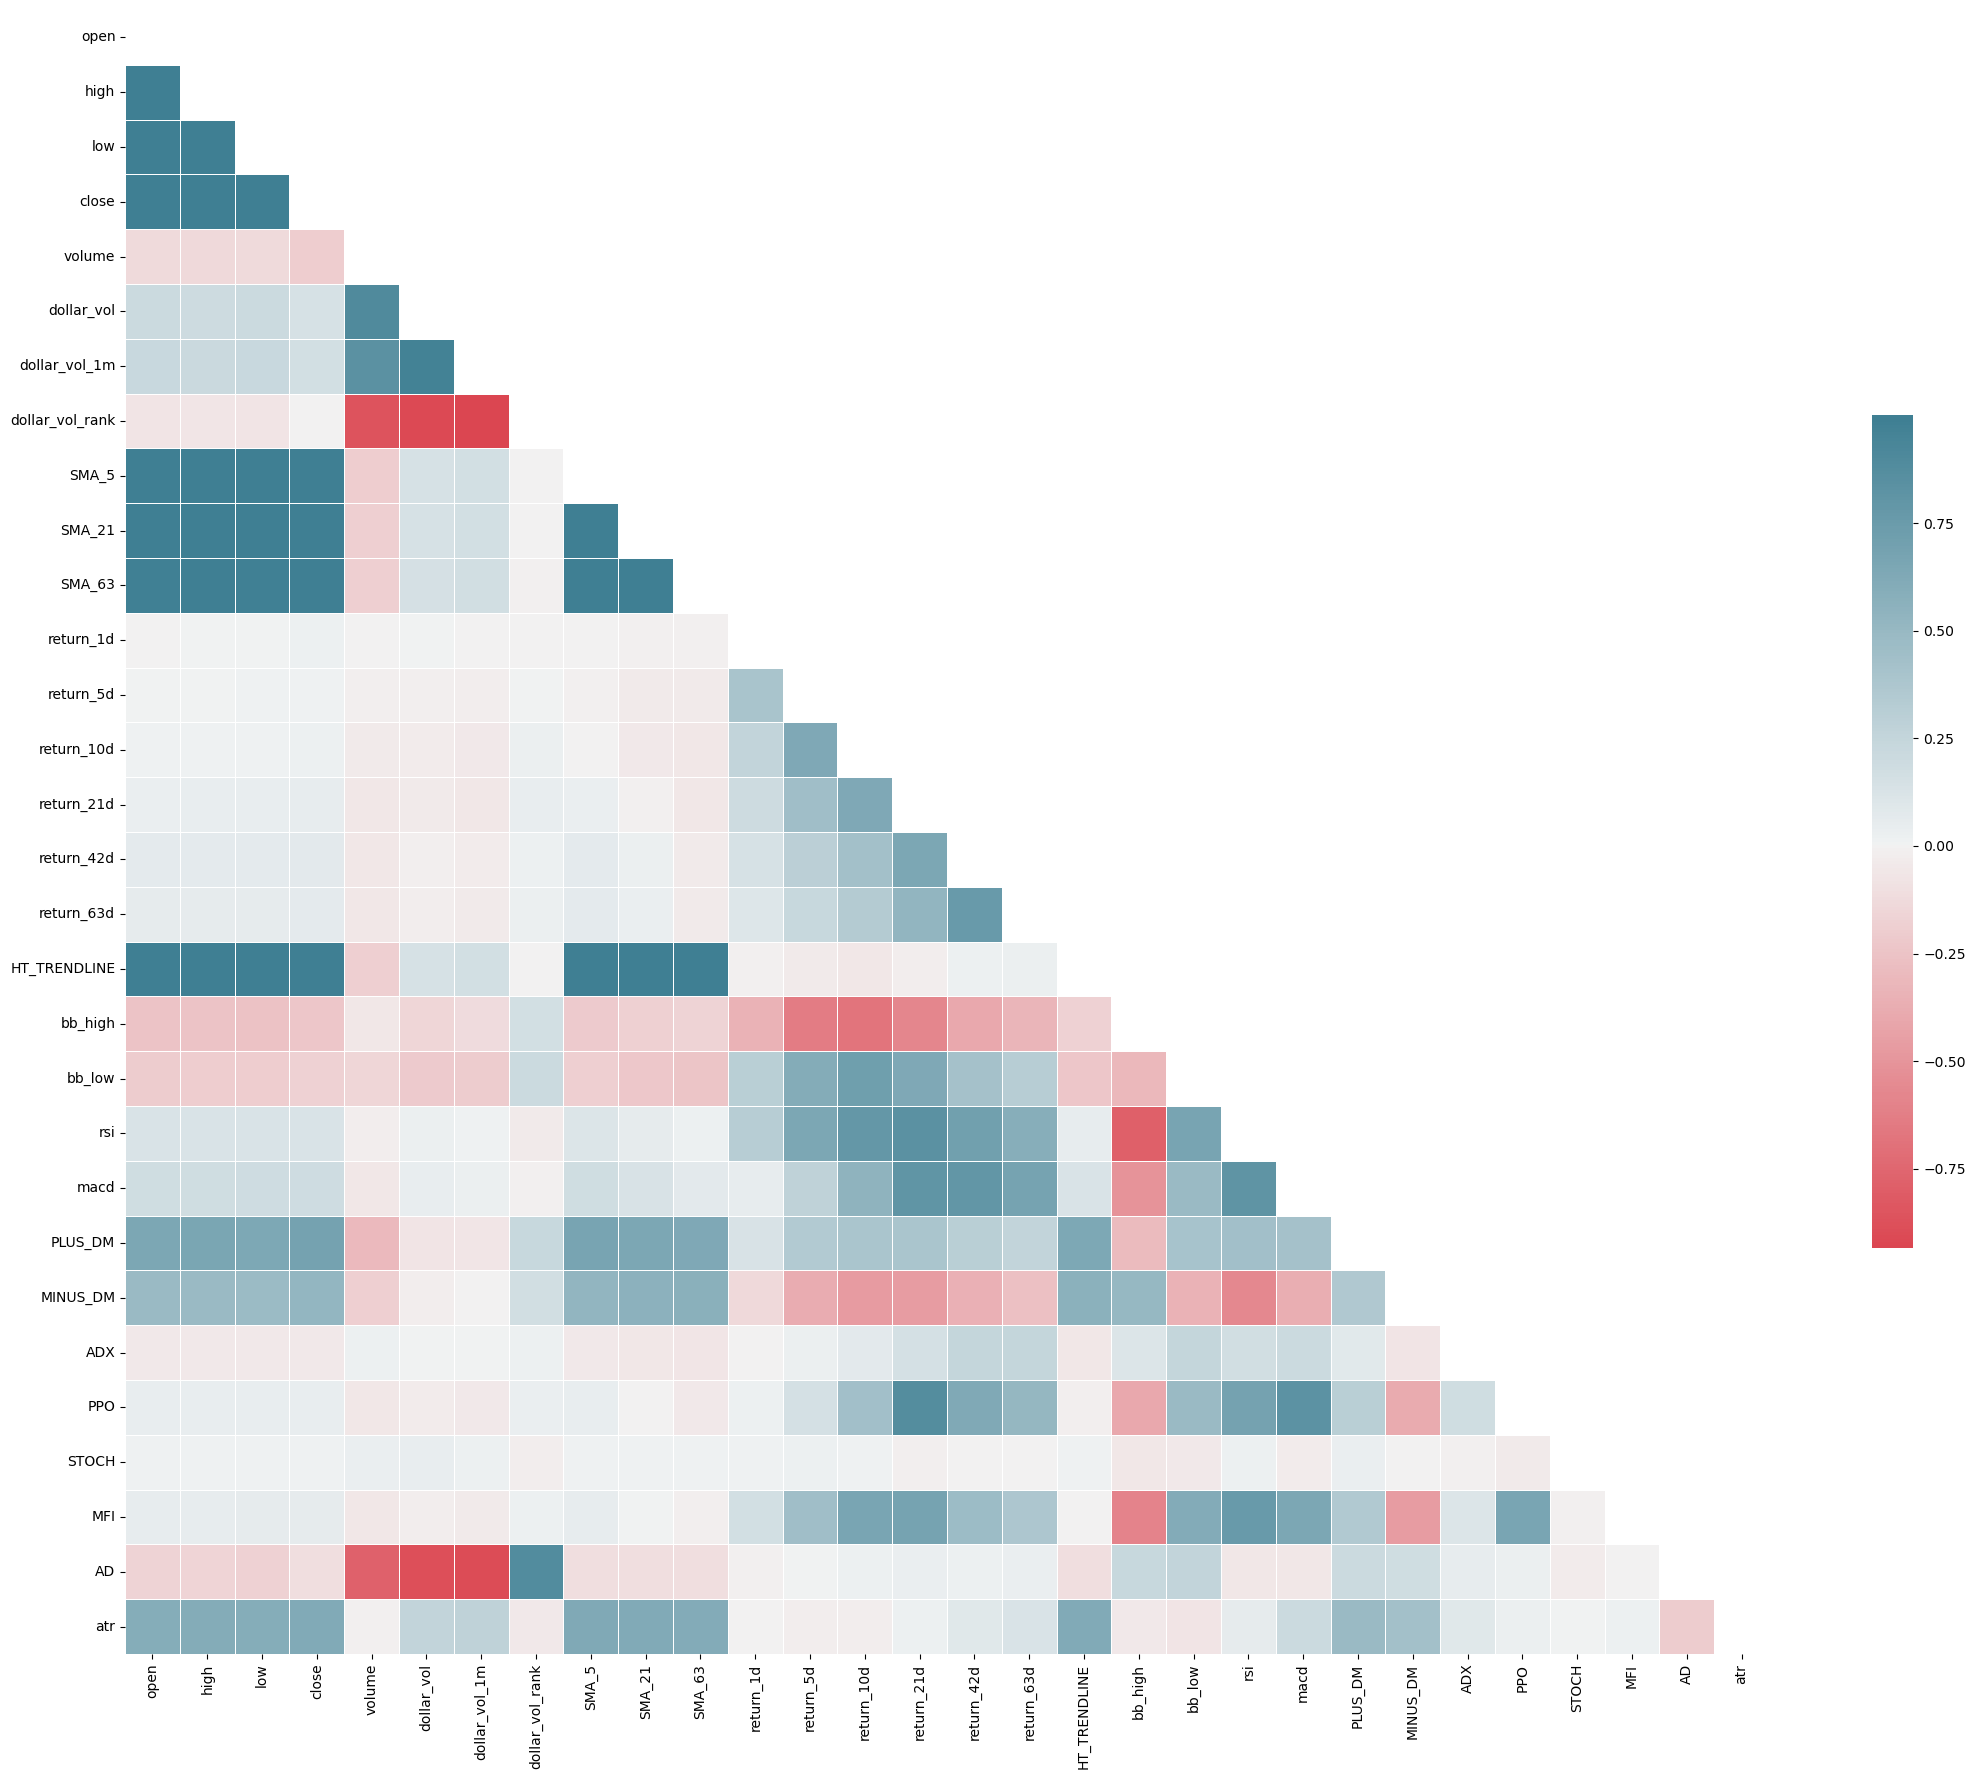

In [102]:
fig, ax = plt.subplots(figsize=(22, 18))
mask = np.triu(np.ones_like(corr_mat,dtype=bool))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr_mat,mask=mask, cmap=cmap, center = 0, square=True,
           linewidths = .5, cbar_kws={"shrink" : .5})
save_fig(f"corr_heatmap{ticker}")
#fig.tight_layout()

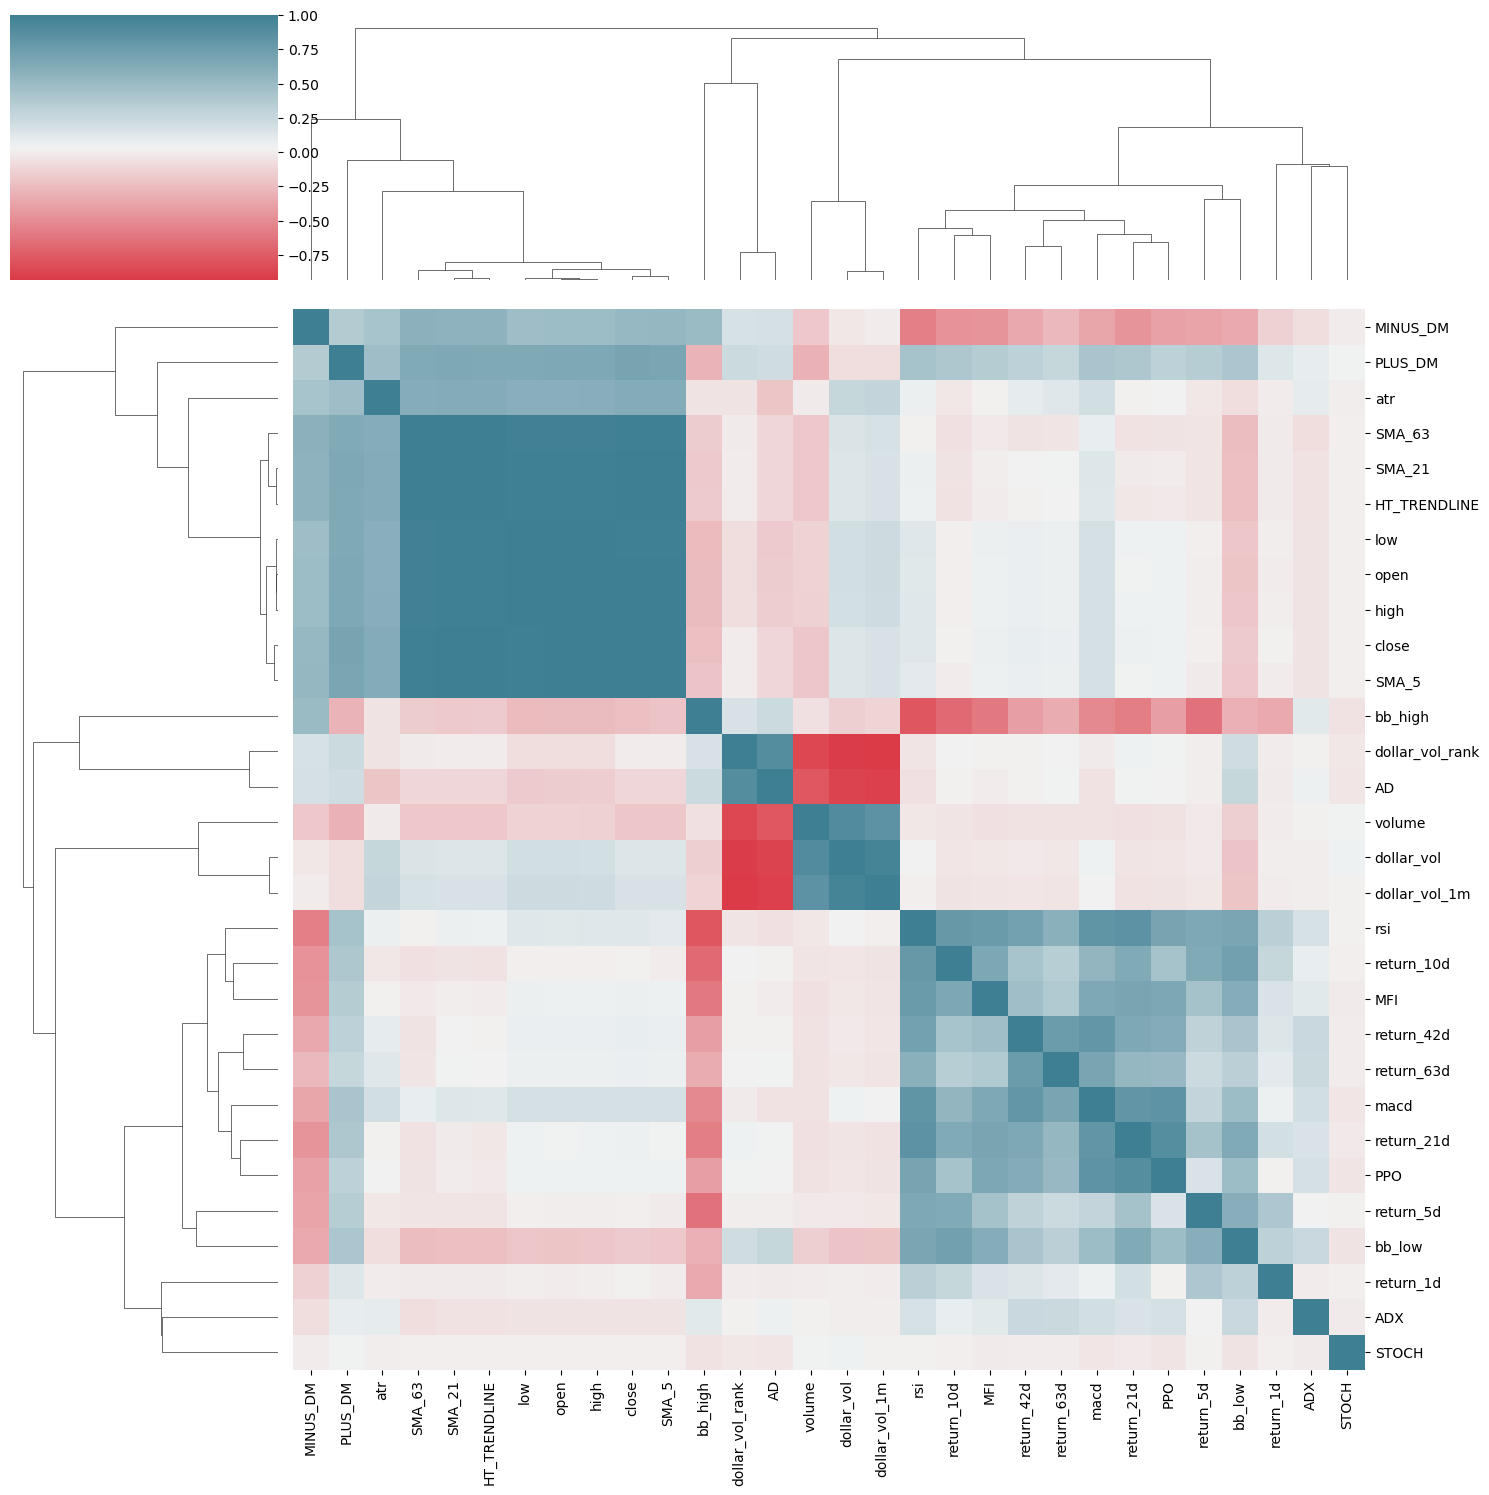

In [103]:
g = sns.clustermap(corr_mat, cmap=cmap, figsize=(15, 15))
save_fig(f"corr_clustermap{ticker}")


## Forward return correlation

In [104]:
fwd_corr = z.drop(['target_1d'], axis = 1).corrwith(z.target_1d, method='spearman')

In [105]:
fwd_corr = fwd_corr.dropna()

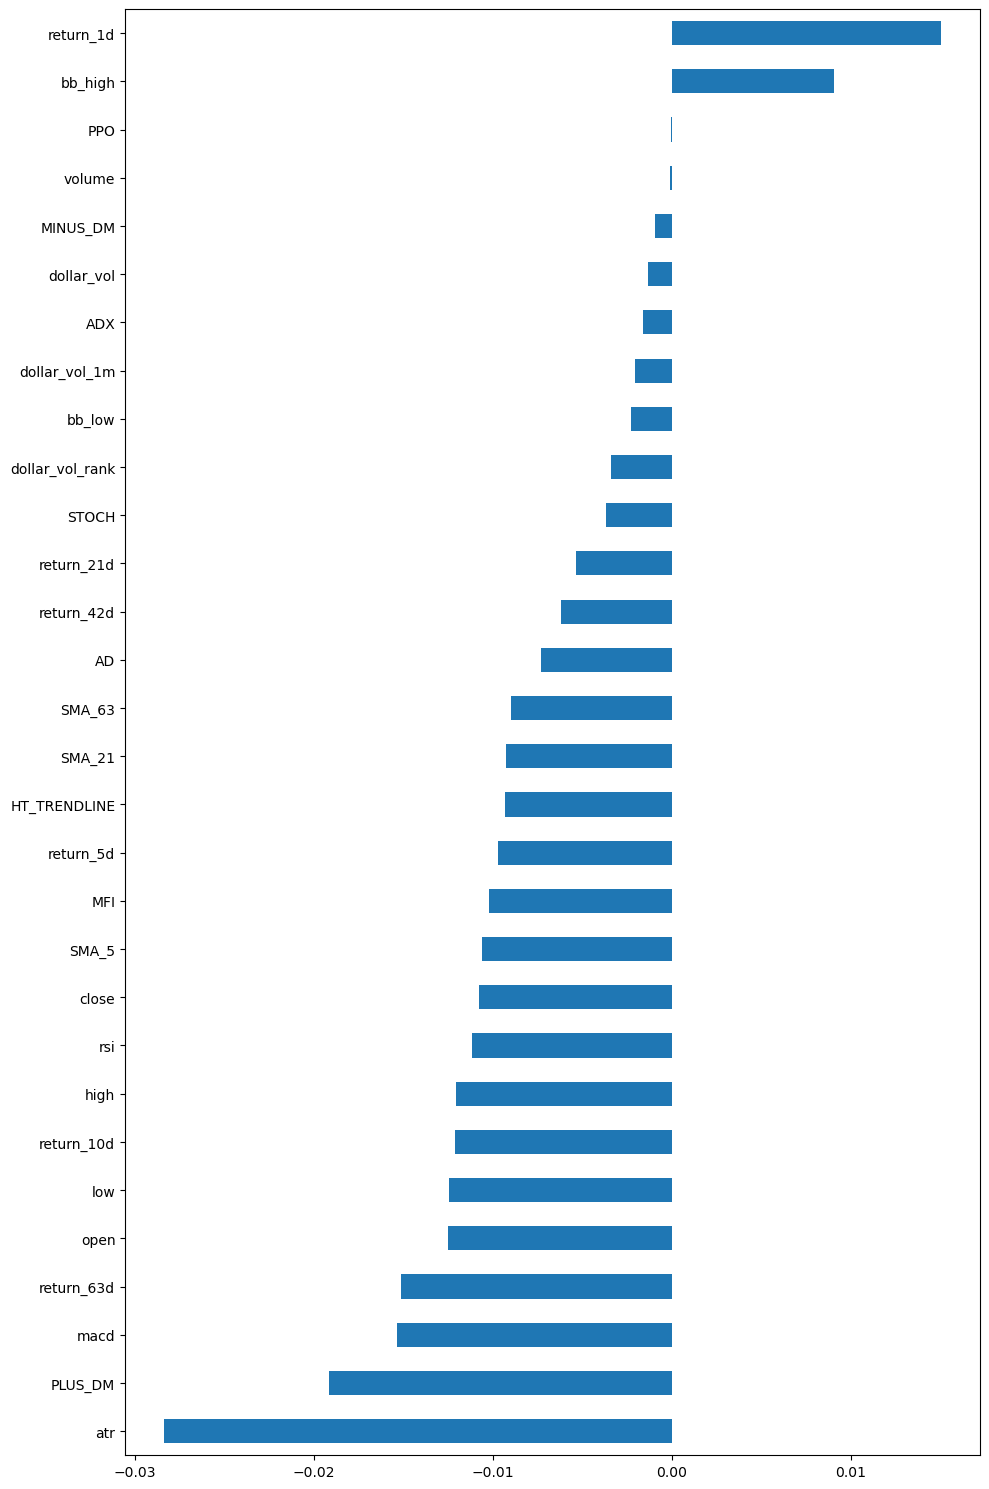

In [106]:
fwd_corr.sort_values().plot.barh(figsize=(10,15), legend = False)
save_fig(f"corr_with_ret_{ticker}")


## Data Exploration

### RSI

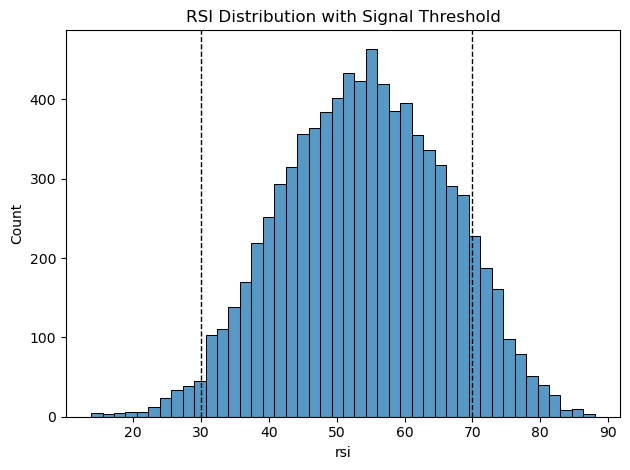

In [107]:
ax = sns.histplot(z.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()
save_fig("RSI_distribution")

### Distribution of bollinger bands

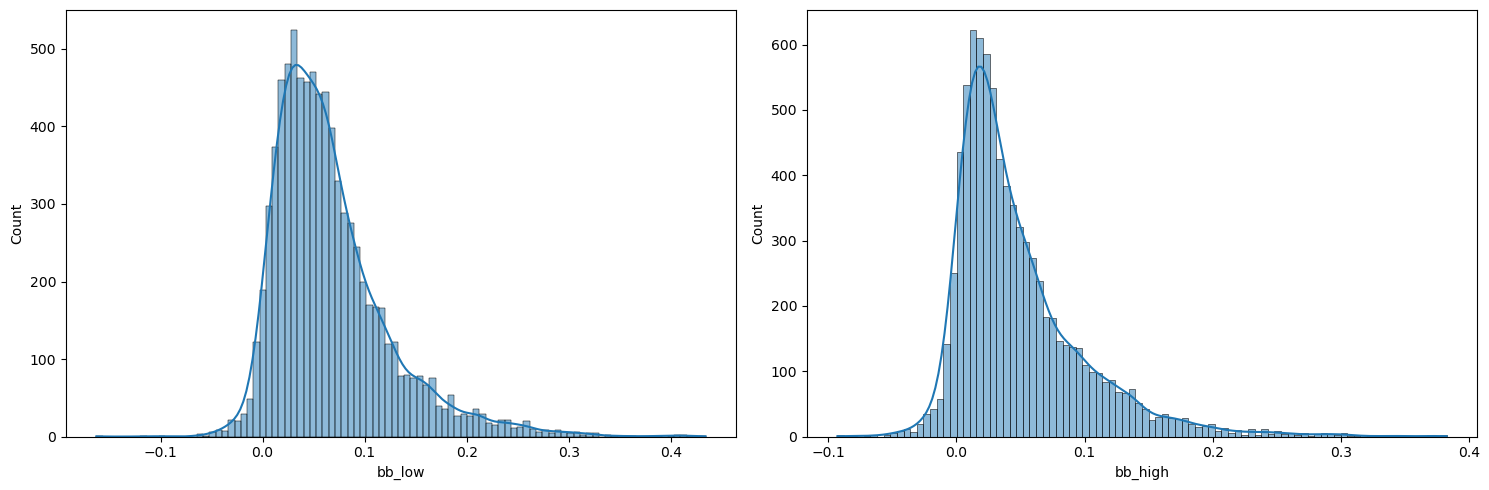

In [108]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(z.loc[:, 'bb_low'].dropna(), ax=axes[0], kde=True)
sns.histplot(z.loc[:, 'bb_high'].dropna(), ax=axes[1], kde=True)
plt.tight_layout()
save_fig("bb_bands")

### distribution of  Average True Range

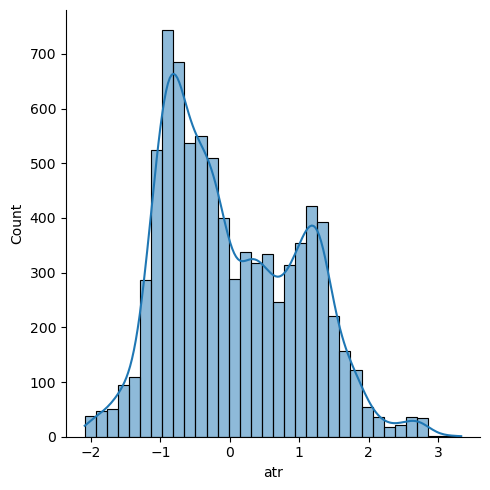

In [109]:
sns.displot(z.atr.dropna(),kde=True)
plt.tight_layout()
save_fig("atr")

### Moving Average Convergence/Divergence

In [110]:
z.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    8,281.0
mean         0.0
std          1.0
min         -5.7
0.1%        -4.4
1%          -2.6
2%          -2.1
3%          -1.9
4%          -1.7
5%          -1.5
50%         -0.0
95%          1.8
96%          1.9
97%          2.1
98%          2.4
99%          2.8
99.9%        4.1
max          4.4
Name: macd, dtype: object

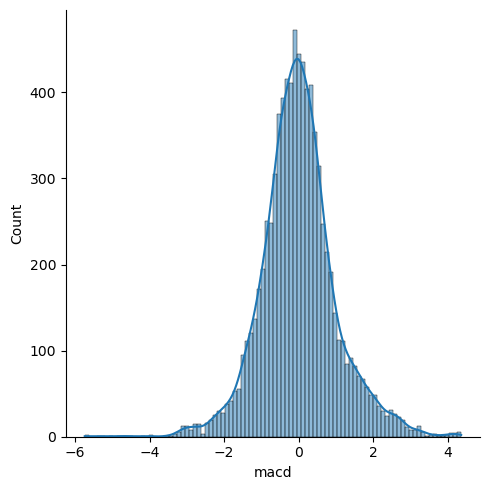

In [111]:
sns.displot(z.macd.dropna(), kde=True)
plt.tight_layout()
save_fig('macd')

### lagged returns

In [112]:
lags = [1, 5, 10, 21, 42, 63]

In [113]:
returns = z.close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,2.80%
min,-84.87%
0.01%,-82.90%
0.1%,-12.13%
1%,-5.86%
50%,0.07%
99%,6.79%
99.9%,14.94%
99.99%,18.52%
max,24.33%
